# Predicting Power Outage Severity in the U.S.

**Name(s)**: Tiantian Zheng, Ziling Xu

**Website Link**: https://cocoxu08.github.io/natural-outages-impact/

In [1]:
# Import necessary libraries for data manipulation and visualization
!pip install openpyxl
import pandas as pd
import numpy as np
from pathlib import Path

# For Step 6
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.metrics import root_mean_squared_error

# For Step 7

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import plotly.express as px
pd.options.plotting.backend = 'plotly'

# from dsc80_utils import * # Feel free to uncomment and use this.

## Step 1: Introduction

### Research Question: 
What characteristics are associated with more severe power outages in the United States? Specifically, how do factors such as geographic location, time of year, climate conditions, and other regional economic indicators influence the severity of power outages in terms of number of customers affected? Which of these factors could help energy companies predict the location and impact of future major outages?

## Step 2: Data Cleaning and Exploratory Data Analysis

We begin by loading and inspecting the data, then perform necessary cleaning steps such as handling missing values in key columns like `POPULATION`, `MONTH`, and `TOTAL.PRICE`.

We also perform basic visualizations to understand distributions and relationships between variables.

In [2]:
# Loading Dataset
# Skip the introduction columns at top

df = pd.read_excel('outage_dataset.xlsx',skiprows=5)
df

,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,numeric,NaN,...,%,%,persons per square mile,persons per square mile,persons per square mile,%,%,%,%,%
1,NaN,1.0,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,NaN,2.0,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,NaN,3.0,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,NaN,4.0,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,NaN,1530.0,2011.0,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,...,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.599649,2.401765,2.401765
1531,NaN,1531.0,2006.0,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,...,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.599649,2.401765,2.401765
1532,NaN,1532.0,2009.0,8.0,South Dakota,SD,RFC,West North Central,0.5,warm,...,56.65,26.73,2038.3,1905.4,4.7,0.3,0.15,98.307744,1.692256,1.692256
1533,NaN,1533.0,2009.0,8.0,South Dakota,SD,MRO,West North Central,0.5,warm,...,56.65,26.73,2038.3,1905.4,4.7,0.3,0.15,98.307744,1.692256,1.692256


In [3]:
# Drop the first row containing units of variables
# Drop the first column
df_no_unit = df.drop(index=0).drop(columns=["variables"])
df_no_unit

,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
1,1.0,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,2.0,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,3.0,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,4.0,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
5,5.0,2015.0,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,1530.0,2011.0,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,2011-12-06 00:00:00,...,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.599649,2.401765,2.401765
1531,1531.0,2006.0,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,NaN,...,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.599649,2.401765,2.401765
1532,1532.0,2009.0,8.0,South Dakota,SD,RFC,West North Central,0.5,warm,2009-08-29 00:00:00,...,56.65,26.73,2038.3,1905.4,4.7,0.3,0.15,98.307744,1.692256,1.692256
1533,1533.0,2009.0,8.0,South Dakota,SD,MRO,West North Central,0.5,warm,2009-08-29 00:00:00,...,56.65,26.73,2038.3,1905.4,4.7,0.3,0.15,98.307744,1.692256,1.692256


In [4]:
# Check all the column name
df_no_unit.columns

Index(['OBS', 'YEAR', 'MONTH', 'U.S._STATE', 'POSTAL.CODE', 'NERC.REGION',
       'CLIMATE.REGION', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY',
       'OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE',
       'OUTAGE.RESTORATION.TIME', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL',
       'HURRICANE.NAMES', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW',
       'CUSTOMERS.AFFECTED', 'RES.PRICE', 'COM.PRICE', 'IND.PRICE',
       'TOTAL.PRICE', 'RES.SALES', 'COM.SALES', 'IND.SALES', 'TOTAL.SALES',
       'RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN', 'RES.CUSTOMERS',
       'COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS', 'RES.CUST.PCT',
       'COM.CUST.PCT', 'IND.CUST.PCT', 'PC.REALGSP.STATE', 'PC.REALGSP.USA',
       'PC.REALGSP.REL', 'PC.REALGSP.CHANGE', 'UTIL.REALGSP', 'TOTAL.REALGSP',
       'UTIL.CONTRI', 'PI.UTIL.OFUSA', 'POPULATION', 'POPPCT_URBAN',
       'POPPCT_UC', 'POPDEN_URBAN', 'POPDEN_UC', 'POPDEN_RURAL',
       'AREAPCT_URBAN', 'AREAPCT_UC', 'PCT_LAND', 'PCT_WATER_TOT',
    

In [5]:
df_no_unit["PCT_CUSTOMERS_AFFECTED"] = df_no_unit["CUSTOMERS.AFFECTED"]/df_no_unit["TOTAL.CUSTOMERS"]
df_no_unit

,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,...,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,PCT_CUSTOMERS_AFFECTED
1,1.0,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,...,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0.026968
2,2.0,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,...,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,NaN
3,3.0,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,...,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0.027059
4,4.0,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,...,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0.026162
5,5.0,2015.0,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,...,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0.093509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,1530.0,2011.0,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,2011-12-06 00:00:00,...,19.9,2192.2,1868.2,3.9,0.27,0.1,97.599649,2.401765,2.401765,0.087476
1531,1531.0,2006.0,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,NaN,...,19.9,2192.2,1868.2,3.9,0.27,0.1,97.599649,2.401765,2.401765,NaN
1532,1532.0,2009.0,8.0,South Dakota,SD,RFC,West North Central,0.5,warm,2009-08-29 00:00:00,...,26.73,2038.3,1905.4,4.7,0.3,0.15,98.307744,1.692256,1.692256,NaN
1533,1533.0,2009.0,8.0,South Dakota,SD,MRO,West North Central,0.5,warm,2009-08-29 00:00:00,...,26.73,2038.3,1905.4,4.7,0.3,0.15,98.307744,1.692256,1.692256,NaN


In [6]:
cols_to_convert = ['OBS', 'YEAR', 'MONTH', 'ANOMALY.LEVEL', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW',
       'CUSTOMERS.AFFECTED', 'RES.PRICE', 'COM.PRICE', 'IND.PRICE',
       'TOTAL.PRICE', 'RES.SALES', 'COM.SALES', 'IND.SALES', 'TOTAL.SALES',
       'RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN', 'RES.CUSTOMERS',
       'COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS', 'RES.CUST.PCT',
       'COM.CUST.PCT', 'IND.CUST.PCT', 'PC.REALGSP.STATE', 'PC.REALGSP.USA',
       'PC.REALGSP.REL', 'PC.REALGSP.CHANGE', 'UTIL.REALGSP', 'TOTAL.REALGSP',
       'UTIL.CONTRI', 'PI.UTIL.OFUSA', 'POPULATION', 'POPPCT_URBAN',
       'POPPCT_UC', 'POPDEN_URBAN', 'POPDEN_UC', 'POPDEN_RURAL',
       'AREAPCT_URBAN', 'AREAPCT_UC', 'PCT_LAND', 'PCT_WATER_TOT',
       'PCT_WATER_INLAND']
df_no_unit[cols_to_convert] = df_no_unit[cols_to_convert].astype(float)
df_no_unit.dtypes

OBS                        float64
YEAR                       float64
MONTH                      float64
U.S._STATE                  object
POSTAL.CODE                 object
NERC.REGION                 object
CLIMATE.REGION              object
ANOMALY.LEVEL              float64
CLIMATE.CATEGORY            object
OUTAGE.START.DATE           object
OUTAGE.START.TIME           object
OUTAGE.RESTORATION.DATE     object
OUTAGE.RESTORATION.TIME     object
CAUSE.CATEGORY              object
CAUSE.CATEGORY.DETAIL       object
HURRICANE.NAMES             object
OUTAGE.DURATION            float64
DEMAND.LOSS.MW             float64
CUSTOMERS.AFFECTED         float64
RES.PRICE                  float64
COM.PRICE                  float64
IND.PRICE                  float64
TOTAL.PRICE                float64
RES.SALES                  float64
COM.SALES                  float64
IND.SALES                  float64
TOTAL.SALES                float64
RES.PERCEN                 float64
COM.PERCEN          

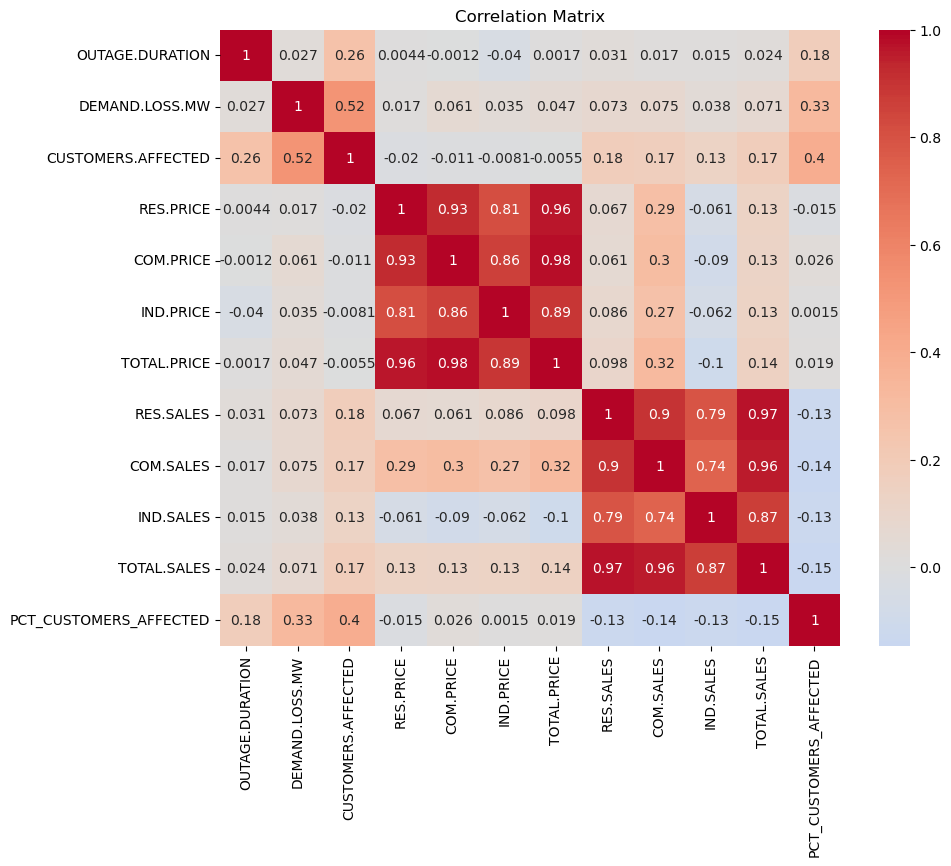

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

col = ["OUTAGE.DURATION", "DEMAND.LOSS.MW","CUSTOMERS.AFFECTED", "RES.PRICE", "COM.PRICE", "IND.PRICE", "TOTAL.PRICE",
       "RES.SALES", "COM.SALES", "IND.SALES", "TOTAL.SALES", "PCT_CUSTOMERS_AFFECTED"]
corr = df_no_unit[col].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

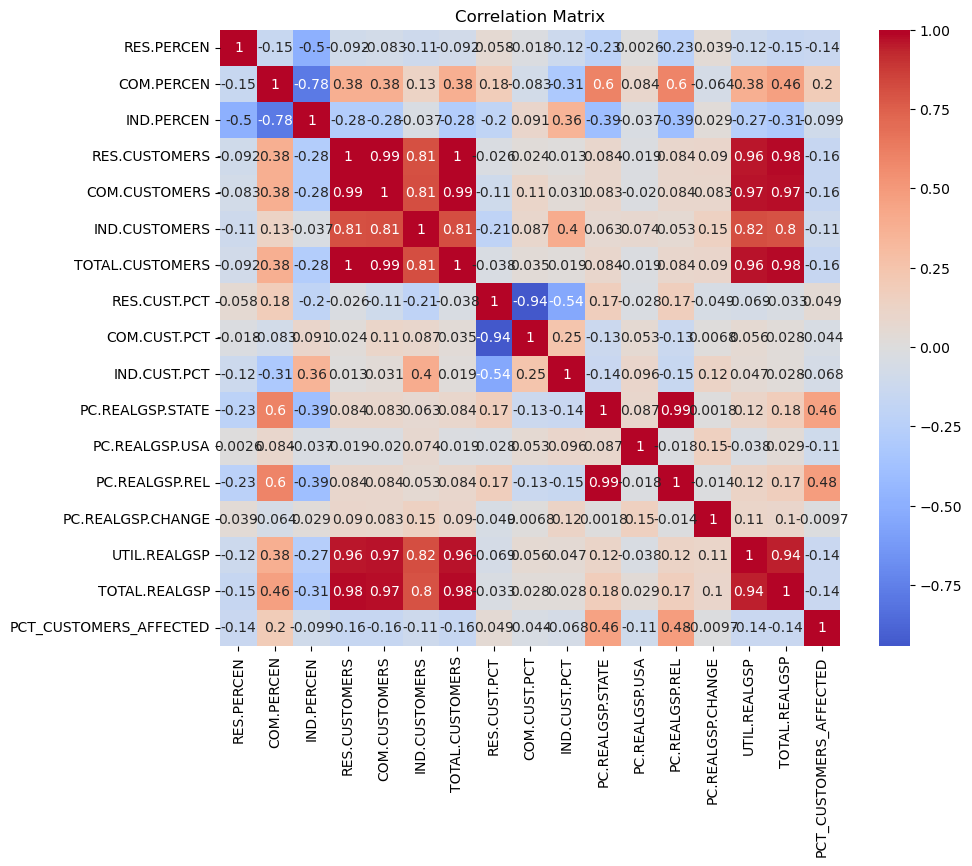

In [8]:
col2 = ["RES.PERCEN", "COM.PERCEN", "IND.PERCEN", "RES.CUSTOMERS", "COM.CUSTOMERS",
         "IND.CUSTOMERS", "TOTAL.CUSTOMERS", "RES.CUST.PCT", "COM.CUST.PCT", "IND.CUST.PCT",
         "PC.REALGSP.STATE", "PC.REALGSP.USA", "PC.REALGSP.REL", "PC.REALGSP.CHANGE", 
         "UTIL.REALGSP", "TOTAL.REALGSP", "PCT_CUSTOMERS_AFFECTED"]


corr = df_no_unit[col2].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

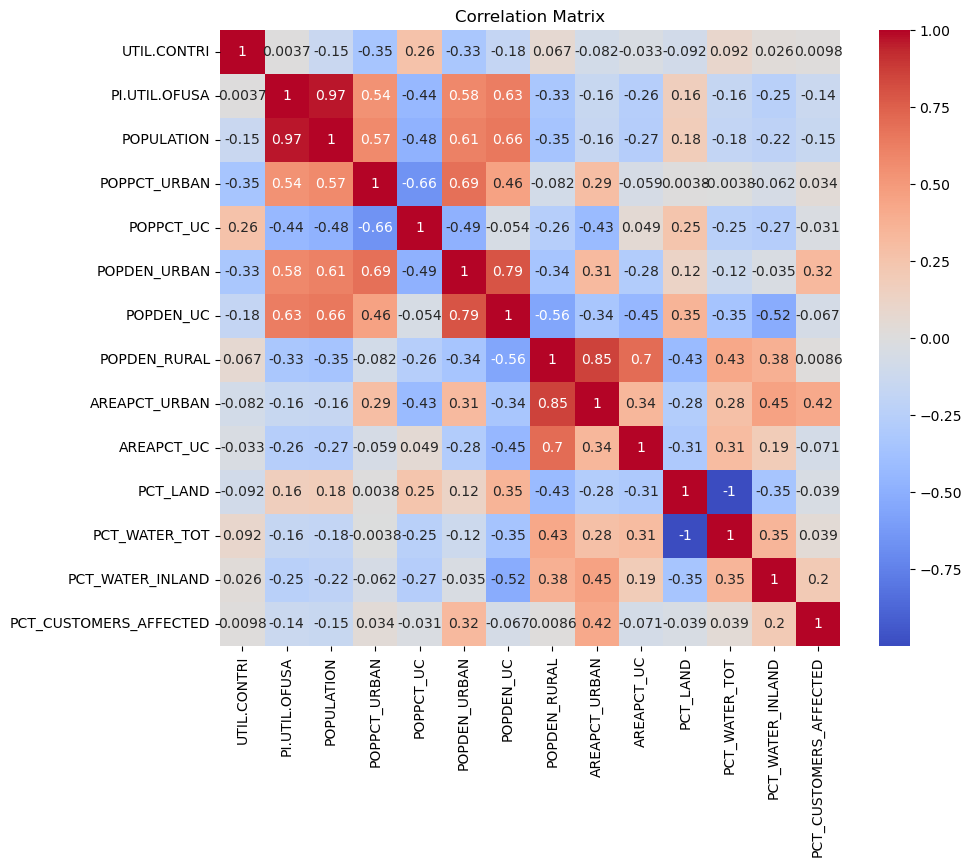

In [9]:
col3 = ["UTIL.CONTRI", "PI.UTIL.OFUSA", 'POPULATION', 'POPPCT_URBAN',
       'POPPCT_UC', 'POPDEN_URBAN', 'POPDEN_UC', 'POPDEN_RURAL',
       'AREAPCT_URBAN', 'AREAPCT_UC', 'PCT_LAND', 'PCT_WATER_TOT',
       'PCT_WATER_INLAND', "PCT_CUSTOMERS_AFFECTED"]


corr = df_no_unit[col3].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

In [10]:
# Select relevant columns
df_cleaned = df_no_unit.get(['YEAR', 'MONTH','U.S._STATE', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL',
                             'CUSTOMERS.AFFECTED', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW','POPULATION',
                             'TOTAL.PRICE','TOTAL.CUSTOMERS', "CLIMATE.REGION", "PCT_CUSTOMERS_AFFECTED", 'PCT_WATER_INLAND','ANOMALY.LEVEL'])
df_cleaned.isna().sum(axis=0)

YEAR                        0
MONTH                       9
U.S._STATE                  0
CAUSE.CATEGORY              0
CAUSE.CATEGORY.DETAIL     471
CUSTOMERS.AFFECTED        443
OUTAGE.DURATION            58
DEMAND.LOSS.MW            705
POPULATION                  0
TOTAL.PRICE                22
TOTAL.CUSTOMERS             0
CLIMATE.REGION              6
PCT_CUSTOMERS_AFFECTED    443
PCT_WATER_INLAND            0
ANOMALY.LEVEL               9
dtype: int64

In [11]:
# Converting "OUTAGE.DURATION" to numeric
df_cleaned.loc[:, "OUTAGE.DURATION"] = pd.to_numeric(df_cleaned["OUTAGE.DURATION"], errors='coerce')

# Drops rows with missing values in 'CUSTOMERS.AFFECTED'
df_cleaned = df_cleaned[df_cleaned['CUSTOMERS.AFFECTED'].notna()].reset_index(drop=True)

# Saves a preview of the cleaned DataFrame to an HTML file
df_cleaned.head().to_html("assets/df_preview.html")
df_cleaned 

,YEAR,MONTH,U.S._STATE,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,CUSTOMERS.AFFECTED,OUTAGE.DURATION,DEMAND.LOSS.MW,POPULATION,TOTAL.PRICE,TOTAL.CUSTOMERS,CLIMATE.REGION,PCT_CUSTOMERS_AFFECTED,PCT_WATER_INLAND,ANOMALY.LEVEL
0,2011.0,7.0,Minnesota,severe weather,NaN,70000.0,3060.0,NaN,5348119.0,9.28,2595696.0,East North Central,0.026968,5.478743,-0.3
1,2010.0,10.0,Minnesota,severe weather,heavy wind,70000.0,3000.0,NaN,5310903.0,8.15,2586905.0,East North Central,0.027059,5.478743,-1.5
2,2012.0,6.0,Minnesota,severe weather,thunderstorm,68200.0,2550.0,NaN,5380443.0,9.19,2606813.0,East North Central,0.026162,5.478743,-0.1
3,2015.0,7.0,Minnesota,severe weather,NaN,250000.0,1740.0,250.0,5489594.0,10.43,2673531.0,East North Central,0.093509,5.478743,1.2
4,2010.0,11.0,Minnesota,severe weather,winter storm,60000.0,1860.0,NaN,5310903.0,8.28,2586905.0,East North Central,0.023194,5.478743,-1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,2003.0,6.0,Idaho,public appeal,NaN,0.0,1548.0,0.0,1363380.0,4.94,687334.0,Northwest,0.000000,1.108066,-0.1
1087,2016.0,3.0,Idaho,intentional attack,sabotage,0.0,0.0,0.0,1680026.0,8.05,849763.0,Northwest,0.000000,1.108066,1.6
1088,2016.0,3.0,Idaho,intentional attack,vandalism,0.0,NaN,0.0,1680026.0,8.05,849763.0,Northwest,0.000000,1.108066,1.6
1089,2011.0,12.0,North Dakota,public appeal,NaN,34500.0,720.0,155.0,685326.0,7.56,394394.0,West North Central,0.087476,2.401765,-0.9


In [12]:
# Visualize the distribution of causes of power outages ("CAUSE.CATEGORY")
fig = px.histogram(df_no_unit, x='CAUSE.CATEGORY', nbins=30, title='Histogram of Cause of Power Outage')
fig.show()
fig.write_html("assets/Histogram_of_Cause_of_Power_Outage.html", include_plotlyjs='cdn')

In [13]:
# Visualize the distribution of power outages across different climate categories (CLIMATE.CATEGORY)
fig2 = px.histogram(df_no_unit, x='CLIMATE.CATEGORY', nbins=30, title='Histogram of Climate of Power Outage')
fig2.show()
fig2.write_html("assets/Histogram_of_CLIMATE.CATEGORY.html", include_plotlyjs='cdn')

In [14]:
# Understand the range and distribution of outage durations

fig2 = px.box(df, y='OUTAGE.DURATION', title='Outage Duration Distribution')
fig2.update_layout(yaxis_title='Duration (hours)')
fig2.show()

In [15]:
# Used the IQR method to filter out statistical outliers in OUTAGE.DURATION
df_new = df_cleaned.copy()
numeric_cols = ["OUTAGE.DURATION"]

# Use IQR to identify outliers and remove these outliers
for col in numeric_cols:
    Q1 = df_new[col].quantile(0.25)
    Q3 = df_new[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
 
    df_new = df_new[(df_new[col] >= lower) & (df_new[col] <= upper)]
df_new

,YEAR,MONTH,U.S._STATE,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,CUSTOMERS.AFFECTED,OUTAGE.DURATION,DEMAND.LOSS.MW,POPULATION,TOTAL.PRICE,TOTAL.CUSTOMERS,CLIMATE.REGION,PCT_CUSTOMERS_AFFECTED,PCT_WATER_INLAND,ANOMALY.LEVEL
0,2011.0,7.0,Minnesota,severe weather,NaN,70000.0,3060.0,NaN,5348119.0,9.28,2595696.0,East North Central,0.026968,5.478743,-0.3
1,2010.0,10.0,Minnesota,severe weather,heavy wind,70000.0,3000.0,NaN,5310903.0,8.15,2586905.0,East North Central,0.027059,5.478743,-1.5
2,2012.0,6.0,Minnesota,severe weather,thunderstorm,68200.0,2550.0,NaN,5380443.0,9.19,2606813.0,East North Central,0.026162,5.478743,-0.1
3,2015.0,7.0,Minnesota,severe weather,NaN,250000.0,1740.0,250.0,5489594.0,10.43,2673531.0,East North Central,0.093509,5.478743,1.2
4,2010.0,11.0,Minnesota,severe weather,winter storm,60000.0,1860.0,NaN,5310903.0,8.28,2586905.0,East North Central,0.023194,5.478743,-1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,2004.0,6.0,Idaho,system operability disruption,NaN,35000.0,95.0,157.0,1391802.0,5.13,701140.0,Northwest,0.049919,1.108066,0.3
1085,2011.0,1.0,Idaho,intentional attack,vandalism,0.0,360.0,0.0,1584134.0,6.54,794925.0,Northwest,0.000000,1.108066,-1.3
1086,2003.0,6.0,Idaho,public appeal,NaN,0.0,1548.0,0.0,1363380.0,4.94,687334.0,Northwest,0.000000,1.108066,-0.1
1087,2016.0,3.0,Idaho,intentional attack,sabotage,0.0,0.0,0.0,1680026.0,8.05,849763.0,Northwest,0.000000,1.108066,1.6


In [16]:
# Full plot
fig3 = px.scatter(df_no_unit, x="OUTAGE.DURATION", y="CUSTOMERS.AFFECTED", title='Scatter Plot of Number of Customers Affected vs Outage Duration')
fig3.update_layout(
    xaxis=dict(range=[0, 50000]),
    height=800)
fig3.show()

In [17]:
# Scatter Plot of Outage duration vs Demand Loss (Zoomed in)
fig4 = px.scatter(df_no_unit, x="OUTAGE.DURATION", y="DEMAND.LOSS.MW", title='Scatter Plot of Number of Customers Affected vs Outage Duration')
fig4.update_layout(
    xaxis=dict(range=[0, 10000]),
    yaxis=dict(range=[0, 1000000]),
    height=800)
fig4.show()

In [18]:
# Scatter Plot of Number of Customers Affected vs Outage Duration (Zoomed in)
fig4 = px.scatter(df_no_unit, x="OUTAGE.DURATION", y="CUSTOMERS.AFFECTED", title='Scatter Plot of Number of Customers Affected vs Outage Duration')
fig4.update_layout(
    xaxis=dict(range=[0, 10000]),
    yaxis=dict(range=[0, 1000000]),
    height=600)
fig4.show()
fig4.write_html("assets/Scatter_OUTAGE_DURATION_vs_CUSTOMERS_AFFECTED.html", include_plotlyjs='cdn')

In [19]:
# Drop rows where 'CUSTOMERS.AFFECTED' is missing
df_no_nan = df_new.dropna(subset=["CUSTOMERS.AFFECTED"])

# average number of customers affected group by cause category and detail
agg = df_no_nan.groupby(["CAUSE.CATEGORY", "CAUSE.CATEGORY.DETAIL"])["CUSTOMERS.AFFECTED"].mean()

# Group by the same columns and count how many outages occurred in each group
agg2 = df_no_nan.groupby(["CAUSE.CATEGORY", "CAUSE.CATEGORY.DETAIL"]).size()

agg = agg.to_frame().reset_index()
agg2 = agg2.to_frame("Count").reset_index()


In [20]:
agg.head()

,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,CUSTOMERS.AFFECTED
0,equipment failure,breaker trip,68500.0
1,equipment failure,cables,120000.0
2,equipment failure,generator trip,19321.0
3,equipment failure,line fault,30000.0
4,equipment failure,relaying malfunction,68530.0


In [21]:
agg2.head()

,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,Count
0,equipment failure,breaker trip,2
1,equipment failure,cables,1
2,equipment failure,generator trip,6
3,equipment failure,line fault,1
4,equipment failure,relaying malfunction,1


In [22]:
# concat side by side
agg_final = pd.concat([agg, agg2["Count"]], axis=1)

# Create a binary column indicating whether the outage cause was severe weather
agg_final["SEVERE_WEATHER"] = (agg_final["CAUSE.CATEGORY"] == "severe weather").astype(int)

# Save the result as an HTML table
agg_final.to_html("assets/agg_final_by_cause.html", index=False)
agg_final.head()

,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,CUSTOMERS.AFFECTED,Count,SEVERE_WEATHER
0,equipment failure,breaker trip,68500.0,2,0
1,equipment failure,cables,120000.0,1,0
2,equipment failure,generator trip,19321.0,6,0
3,equipment failure,line fault,30000.0,1,0
4,equipment failure,relaying malfunction,68530.0,1,0


## Step 3: Assessment of Missingness

In [23]:
# Check number of missing values in each column
df_cleaned.isnull().sum()

YEAR                        0
MONTH                       7
U.S._STATE                  0
CAUSE.CATEGORY              0
CAUSE.CATEGORY.DETAIL     321
CUSTOMERS.AFFECTED          0
OUTAGE.DURATION            35
DEMAND.LOSS.MW            378
POPULATION                  0
TOTAL.PRICE                16
TOTAL.CUSTOMERS             0
CLIMATE.REGION              6
PCT_CUSTOMERS_AFFECTED      0
PCT_WATER_INLAND            0
ANOMALY.LEVEL               7
dtype: int64

In [24]:
# MAR example
# Create a new binary column indicating if 'DEMAND.LOSS.MW' is missing
df_check_missing = df_cleaned.copy()
df_check_missing['DEMAND_LOSS_IS_MISSING'] = df_check_missing['DEMAND.LOSS.MW'].isna()
observed = df_check_missing.groupby("YEAR")["DEMAND_LOSS_IS_MISSING"].mean().var()

# permutation test
np.random.seed(42)
stats_customers = []

for _ in range(1000):
    shuffled = np.random.permutation(df_check_missing["DEMAND_LOSS_IS_MISSING"])
    shuffled_stat = df_check_missing.assign(shuffled_missing=shuffled).groupby("YEAR")["shuffled_missing"].mean().var()
    stats_customers.append(shuffled_stat)

# Calculate p-value
p_value = np.mean(np.array(stats_customers) >=observed)
print("p-value:", p_value)

p-value: 0.0


In [25]:
# Plot permutation distribution with observed variance marked
fig = px.histogram(
    x=stats_customers,
    nbins=40,
    title="Permutation Test: Variance in DEMAND.LOSS.MW Missingness by YEAR",
    labels={'x': 'Test Statistic (Variance)', 'y': 'Count'}
)
fig.add_vline(
    x=observed,
    line_color="red",
    annotation_text="Observed",
    annotation_position="top right"
)
fig.show()
fig.write_html("assets/Permutation_Test_Variance_in_DEMAND.LOSS.MW_Missingness_by_YEAR.html", include_plotlyjs='cdn')

In [26]:
def plot_kde_by_missingness(df, missing_col, target_col, title, save_path=None):
    fig = px.histogram(
        df,
        x=target_col,
        color=missing_col,
        histnorm='probability density',
        nbins=50,
        barmode='overlay',
        opacity=0.5,
        title=title,
        labels={target_col: target_col, missing_col: f"{target_col} is missing"}
    )
    fig.update_layout(template="plotly_white")
    
    if save_path:
        fig.write_html(save_path, include_plotlyjs='cdn')
    fig.show()

# Visualize the distribution of YEAR split by whether DEMAND.LOSS.MW is missing
plot_kde_by_missingness(
    df=df_check_missing,
    missing_col="DEMAND_LOSS_IS_MISSING",
    target_col="YEAR",
    title="YEAR Distribution by Missingness of DEMAND.LOSS.MW",
    save_path="assets/year_distribution_missingness.html")

In [27]:
np.random.seed(42)
df_check_missing['DEMAND_LOSS_IS_MISSING'] = df_check_missing['DEMAND.LOSS.MW'].isna()
observed_var = df_check_missing.groupby("TOTAL.PRICE")["DEMAND_LOSS_IS_MISSING"].mean().var()

# permutation test using TOTAL.PRICE as the grouping variable
stats = []
for i in range(1000):
    shuffled = np.random.permutation(df_check_missing["DEMAND_LOSS_IS_MISSING"])
    shuffled_stat = df_check_missing.assign(shuffled_missing=shuffled).groupby("TOTAL.PRICE")["shuffled_missing"].mean().var()
    stats.append(shuffled_stat)

# Calculate p-value
p_value = np.mean(np.array(stats) >= observed_var)
print("p-value:", p_value)

p-value: 0.108


In [28]:
# Plot the permutation results with the observed
fig = px.histogram(x=stats,nbins=40,title="Permutation Test: Variance in DEMAND.LOSS.MW Missingness by TOTAL.PRICE",
    labels={'x': 'Test Statistic (Variance)', 'y': 'Count'}
)
fig.add_vline(x=observed_var, line_color="red", annotation_text="Observed", annotation_position="top right")
fig.show()
fig.write_html("assets/Permutation_Test_Variance_in_DEMAND.LOSS.MW_Missingness_by_TOTAL.PRICE.html", include_plotlyjs='cdn')

In [29]:
# Visualize TOTAL.PRICE distribution by whether DEMAND.LOSS.MW is missing
plot_kde_by_missingness(
    df=df_check_missing,
    missing_col="DEMAND_LOSS_IS_MISSING",
    target_col="TOTAL.PRICE",
    title="TOTAL.PRICE Distribution by Missingness of DEMAND.LOSS.MW",
    save_path="assets/total_price_distribution_missingness.html"
)

## Step 4: Hypothesis Testing

In [30]:
# Step 1: Define Observed Test Statistic
# Split the data into two groups: severe weather and non-severe weather
natural = agg_final[agg_final["SEVERE_WEATHER"] == 1]["CUSTOMERS.AFFECTED"]
non_natural = agg_final[agg_final["SEVERE_WEATHER"] == 0]["CUSTOMERS.AFFECTED"]

# Calculate the observed difference
observed_diff = natural.mean() - non_natural.mean()
print("Observed difference:", observed_diff)

Observed difference: 108544.95125862498


In [31]:
# Step 2: Permutation Test
diffs = []
n_reps = 5000

# Extract original customers affected as an array
affected = agg_final["CUSTOMERS.AFFECTED"].values
labels = agg_final["SEVERE_WEATHER"].values

# Run many permutations to build null distribution
for _ in range(n_reps):
    # Shuffle the labels
    shuffled_labels = np.random.permutation(labels)
    
    # Compute mean difference based on shuffled labels
    diff = affected[shuffled_labels == 1].mean() - affected[shuffled_labels == 0].mean()
    diffs.append(diff)

diffs = np.array(diffs)
diffs

array([ 27706.21251861, -61705.79010092,  -9607.65577331, ...,
        35802.08293964,  36971.14087165,  32100.97106433])

In [32]:
# Step 3: p-value
p_value = np.mean(diffs >= observed_diff)
print("P-value:", p_value)


P-value: 0.0


In [33]:
# Step 4: Visualize
# Plot the distribution of simulated differences
df_plot = pd.DataFrame({'Diff': diffs})
fig = px.histogram(df_plot, x="Diff", nbins=50, title="Null Distribution of Mean Differences")
fig.add_vline(x=observed_diff, line_dash="dash", line_color="red", annotation_text="Observed")
fig.write_html("assets/null_dist_severe_weather.html", include_plotlyjs='cdn')
fig.show()

## Step 5: Framing a Prediction Problem

We aim to predict the severity of a power outage as measured by the number of customers affected (CUSTOMERS.AFFECTED) using features available at the start of the outage.

Problem Type:
Regression

Response Variable (Target):
PCT.CUSTOMERS.AFFECTED — the percentage of customers affected by the outage.

Predictor Variables (Features):

"SEVERE.WEATHER == True": binary indicator if the cause was severe weather.

"POPULATION": total population in the affected region.

"TOTAL.CUSTOMERS": total utility customers in the region (residential + commercial + industrial).

"MONTH": numeric month the outage occurred, to account for seasonal patterns.

Why this makes sense:
All predictors are available at the time of prediction (start of outage). These features represent potential scale (population, customers), seasonal risk (month), and severity driver (cause category). Together, they offer a meaningful foundation to estimate the scope of an outage.

Evaluation Metric:
We use Root Mean Squared Error (RMSE) to evaluate the model’s predictive performance. RMSE is suitable here because:

Our target is numeric and positive.

We want to penalize larger errors more heavily (large under/over-predictions in customer count are more impactful).



## Step 6: Baseline Model

In [34]:
df_cleaned.isna().sum()

YEAR                        0
MONTH                       7
U.S._STATE                  0
CAUSE.CATEGORY              0
CAUSE.CATEGORY.DETAIL     321
CUSTOMERS.AFFECTED          0
OUTAGE.DURATION            35
DEMAND.LOSS.MW            378
POPULATION                  0
TOTAL.PRICE                16
TOTAL.CUSTOMERS             0
CLIMATE.REGION              6
PCT_CUSTOMERS_AFFECTED      0
PCT_WATER_INLAND            0
ANOMALY.LEVEL               7
dtype: int64

In [35]:
# Fill missing values in specific numeric columns with their column means

df_cleaned_mfilled = df_cleaned.copy()
cols_to_fill = ["POPULATION", "MONTH", "TOTAL.PRICE", "DEMAND.LOSS.MW"]

for col in cols_to_fill:
    df_cleaned_mfilled[col] = df_cleaned_mfilled[col].fillna(df_cleaned_mfilled[col].mean())

In [36]:
# Create binary columns that indicate whether the outage was caused by severe weather or not
df_cleaned_mfilled["SEVERE.WEATHER == True"] = (df_cleaned_mfilled['CAUSE.CATEGORY'] == "severe weather").astype(int)
df_cleaned_mfilled["SEVERE.WEATHER == False"] = (df_cleaned_mfilled['CAUSE.CATEGORY'] != "severe weather").astype(int)


In [37]:
# Visualize Distribution of Customers Affected
px.histogram(df_cleaned_mfilled["PCT_CUSTOMERS_AFFECTED"])

In [38]:
df_new_2 = df_cleaned_mfilled.copy()
numeric_cols = ["PCT_CUSTOMERS_AFFECTED"]

# Remove statistical outliers in 'CUSTOMERS.AFFECTED' using the IQR method
for col in numeric_cols:
    Q1 = df_new_2[col].quantile(0.25)
    Q3 = df_new_2[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
 
    df_new_2 = df_new_2[(df_new_2[col] >= lower) & (df_new_2[col] <= upper)]
df_new_2

,YEAR,MONTH,U.S._STATE,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,CUSTOMERS.AFFECTED,OUTAGE.DURATION,DEMAND.LOSS.MW,POPULATION,TOTAL.PRICE,TOTAL.CUSTOMERS,CLIMATE.REGION,PCT_CUSTOMERS_AFFECTED,PCT_WATER_INLAND,ANOMALY.LEVEL,SEVERE.WEATHER == True,SEVERE.WEATHER == False
0,2011.0,7.000000,Minnesota,severe weather,NaN,70000.0,3060.0,438.660589,5348119.0,9.280000,2595696.0,East North Central,0.026968,5.478743,-0.3,1,0
1,2010.0,10.000000,Minnesota,severe weather,heavy wind,70000.0,3000.0,438.660589,5310903.0,8.150000,2586905.0,East North Central,0.027059,5.478743,-1.5,1,0
2,2012.0,6.000000,Minnesota,severe weather,thunderstorm,68200.0,2550.0,438.660589,5380443.0,9.190000,2606813.0,East North Central,0.026162,5.478743,-0.1,1,0
4,2010.0,11.000000,Minnesota,severe weather,winter storm,60000.0,1860.0,438.660589,5310903.0,8.280000,2586905.0,East North Central,0.023194,5.478743,-1.4,1,0
5,2010.0,7.000000,Minnesota,severe weather,tornadoes,63000.0,2970.0,438.660589,5310903.0,9.120000,2586905.0,East North Central,0.024353,5.478743,-0.9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,2003.0,6.000000,Idaho,public appeal,NaN,0.0,1548.0,0.000000,1363380.0,4.940000,687334.0,Northwest,0.000000,1.108066,-0.1,0,1
1087,2016.0,3.000000,Idaho,intentional attack,sabotage,0.0,0.0,0.000000,1680026.0,8.050000,849763.0,Northwest,0.000000,1.108066,1.6,0,1
1088,2016.0,3.000000,Idaho,intentional attack,vandalism,0.0,NaN,0.000000,1680026.0,8.050000,849763.0,Northwest,0.000000,1.108066,1.6,0,1
1089,2011.0,12.000000,North Dakota,public appeal,NaN,34500.0,720.0,155.000000,685326.0,7.560000,394394.0,West North Central,0.087476,2.401765,-0.9,0,1


In [39]:
# Box Plot of Cleaned Customers Affected Distribution
fig3 = px.box(df_new_2, y='PCT_CUSTOMERS_AFFECTED', title='Percentage of Customers Affected Distribution')
fig3.update_layout(yaxis_title='Percentage of Customer Affected')
fig3.show()

In [40]:
# Customer density
df_new_2["CUSTOMER_DENSITY"] = df_new_2["TOTAL.CUSTOMERS"] / df_new_2["POPULATION"]


# Categorical month encoding
def mon_to_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_new_2['SEASON'] = df_new_2['MONTH'].apply(mon_to_season)


# Log-transformed population
df_new_2["LOG_POPULATION"] = np.log1p(df_new_2["POPULATION"])

df_new_2.to_html("assets/final_cleaned_df_step_6.html", index=False)
df_new_2.head()

,YEAR,MONTH,U.S._STATE,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,CUSTOMERS.AFFECTED,OUTAGE.DURATION,DEMAND.LOSS.MW,POPULATION,TOTAL.PRICE,TOTAL.CUSTOMERS,CLIMATE.REGION,PCT_CUSTOMERS_AFFECTED,PCT_WATER_INLAND,ANOMALY.LEVEL,SEVERE.WEATHER == True,SEVERE.WEATHER == False,CUSTOMER_DENSITY,SEASON,LOG_POPULATION
0,2011.0,7.0,Minnesota,severe weather,NaN,70000.0,3060.0,438.660589,5348119.0,9.28,2595696.0,East North Central,0.026968,5.478743,-0.3,1,0,0.485347,Summer,15.492256
1,2010.0,10.0,Minnesota,severe weather,heavy wind,70000.0,3000.0,438.660589,5310903.0,8.15,2586905.0,East North Central,0.027059,5.478743,-1.5,1,0,0.487093,Fall,15.485273
2,2012.0,6.0,Minnesota,severe weather,thunderstorm,68200.0,2550.0,438.660589,5380443.0,9.19,2606813.0,East North Central,0.026162,5.478743,-0.1,1,0,0.484498,Summer,15.498281
4,2010.0,11.0,Minnesota,severe weather,winter storm,60000.0,1860.0,438.660589,5310903.0,8.28,2586905.0,East North Central,0.023194,5.478743,-1.4,1,0,0.487093,Fall,15.485273
5,2010.0,7.0,Minnesota,severe weather,tornadoes,63000.0,2970.0,438.660589,5310903.0,9.12,2586905.0,East North Central,0.024353,5.478743,-0.9,1,0,0.487093,Summer,15.485273


In [41]:
# Train-Test Split

X = df_new_2[['SEVERE.WEATHER == True', "LOG_POPULATION", "CUSTOMER_DENSITY", "SEASON"]]
X_train, X_test, y_train, y_test = train_test_split(X, df_new_2["PCT_CUSTOMERS_AFFECTED"], test_size=0.2, random_state=42)

# One-hot encode the categorical 'SEASON' column
preproc = ColumnTransformer(
    transformers=[
        ('categorical_cols', OneHotEncoder(handle_unknown='ignore'), ['SEASON'])
    ],
    remainder='passthrough'
)

# Define pipeline: preprocessing + linear regression
pl = Pipeline([
    ('preprocessor', preproc),
    ('lin-reg', LinearRegression())
])

pl.fit(X_train, y_train)
pred_train = pl.predict(X_train)
pred_test = pl.predict(X_test)

rmse_test =root_mean_squared_error(y_test, pred_test)
rmse_train = root_mean_squared_error(y_train, pred_train)
print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)

Train RMSE: 0.017372044617043524
Test RMSE: 0.01698498642585826


## Step 7: Final Model

In [42]:
# Feature Engineering
# Quartile binning for population
df_new_2["LOG_CUSTOMER_AFFECTED"] = np.log1p(df_new_2["CUSTOMERS.AFFECTED"])

# Log-transformed target
df_new_2["POP_QUARTILE"] = pd.qcut(df_new_2["POPULATION"], q=4, labels=["Q1", "Q2", "Q3", "Q4"])



In [43]:
# Linear Regression with Train-Test Split
# Define input features and target
X = df_new_2[["SEVERE.WEATHER == True", "POPULATION", "SEASON"]]
y = df_new_2["PCT_CUSTOMERS_AFFECTED"]

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode the categorical 'SEASON' column
preproc = ColumnTransformer(
    transformers=[
        ('categorical_cols', OneHotEncoder(handle_unknown='ignore'), ['SEASON'])
    ],
    remainder='passthrough'
)

# Define pipeline: preprocessing + linear regression
pl2 = Pipeline([
    ('preprocessor', preproc),
    ('lin-reg', LinearRegression())
])

# Fit on training data
pl2.fit(X_train, y_train)

# Predict on test data
preds_train = pl2.predict(X_train)
preds_test = pl2.predict(X_test)


# Evaluate using RMSE
rmse_test =root_mean_squared_error(y_test, preds_test)
rmse_train = root_mean_squared_error(y_train, preds_train)
print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)

Train RMSE: 0.017256074892374493
Test RMSE: 0.016909693536396216


In [44]:
# Train a Baseline Linear Regression Model
X = df_new_2[['SEVERE.WEATHER == True', "POPULATION", "MONTH", "DEMAND.LOSS.MW"]]
y = df_new_2["PCT_CUSTOMERS_AFFECTED"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Fit on training data
lr = LinearRegression()
lr.fit(X_train, y_train)
# Evaluate Model
preds_train = lr.predict(X_train)
preds_test = lr.predict(X_test)


# Evaluate using RMSE
rmse_test =root_mean_squared_error(y_test, preds_test)
rmse_train = root_mean_squared_error(y_train, preds_train)
print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)

Train RMSE: 0.01695836837969104
Test RMSE: 0.01653845297490461


In [45]:
# Use SEASON + POP_QUARTILE as categorical; CUSTOMER_DENSITY as numeric
X = df_new_2[["SEVERE.WEATHER == True", "POPULATION", "SEASON",'PCT_WATER_INLAND', 'TOTAL.PRICE', "DEMAND.LOSS.MW"]]
y = df_new_2["PCT_CUSTOMERS_AFFECTED"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['SEASON'])
    ], remainder='passthrough')

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('model', RandomForestRegressor(random_state=44))
])
param_grid = {
    'model__n_estimators': [100],
    'model__max_depth': [5, 10],
    'model__min_samples_split': [2, 5]
}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error')

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
preds_test = best_model.predict(X_test)
preds_train = best_model.predict(X_train)

# Evaluate
rmse_test =root_mean_squared_error(y_test, preds_test)
rmse_train = root_mean_squared_error(y_train, preds_train)
print("Random Forest RMSE on train set:", rmse_train)
print("Random Forest RMSE on test set:", rmse_test)


Random Forest RMSE on train set: 0.012661903435839027
Random Forest RMSE on test set: 0.014848548638737653


## Step 8: Fairness Analysis

In [46]:
df_new_2[df_new_2['ANOMALY.LEVEL']>=0]

,YEAR,MONTH,U.S._STATE,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,CUSTOMERS.AFFECTED,OUTAGE.DURATION,DEMAND.LOSS.MW,POPULATION,TOTAL.PRICE,...,PCT_CUSTOMERS_AFFECTED,PCT_WATER_INLAND,ANOMALY.LEVEL,SEVERE.WEATHER == True,SEVERE.WEATHER == False,CUSTOMER_DENSITY,SEASON,LOG_POPULATION,LOG_CUSTOMER_AFFECTED,POP_QUARTILE
7,2015.0,3.0,Minnesota,intentional attack,sabotage,5941.0,155.0,20.000000,5489594.0,9.03,...,0.002222,5.478743,0.6,0,1,0.487018,Spring,15.518365,8.689801,Q1
10,2005.0,9.0,Minnesota,severe weather,tornadoes,200000.0,8880.0,438.660589,5119598.0,7.03,...,0.080811,5.478743,0.0,1,0,0.483419,Fall,15.448587,12.206078,Q1
13,2014.0,6.0,Minnesota,severe weather,thunderstorm,55951.0,60.0,438.660589,5457125.0,10.02,...,0.021188,5.478743,0.0,1,0,0.483906,Summer,15.512433,10.932249,Q1
16,2012.0,7.0,Tennessee,severe weather,wind storm,50001.0,1260.0,438.660589,6455469.0,9.67,...,0.015676,2.156891,0.1,1,0,0.494088,Summer,15.680438,10.819818,Q2
17,2015.0,7.0,Tennessee,intentional attack,vandalism,0.0,NaN,0.000000,6600299.0,9.70,...,0.000000,2.156891,1.2,0,1,0.494024,Summer,15.702626,0.000000,Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076,2015.0,6.0,Kansas,severe weather,NaN,110000.0,NaN,438.660589,2911641.0,10.48,...,0.074104,0.632004,1.0,1,0,0.509814,Summer,14.884228,11.608245,Q1
1081,2006.0,6.0,Hawaii,system operability disruption,NaN,29300.0,237.0,120.000000,1309731.0,21.45,...,0.063199,0.384193,0.0,0,1,0.353977,Summer,14.085333,10.285377,Q1
1084,2004.0,6.0,Idaho,system operability disruption,NaN,35000.0,95.0,157.000000,1391802.0,5.13,...,0.049919,1.108066,0.3,0,1,0.503764,Summer,14.146111,10.463132,Q1
1087,2016.0,3.0,Idaho,intentional attack,sabotage,0.0,0.0,0.000000,1680026.0,8.05,...,0.000000,1.108066,1.6,0,1,0.505803,Spring,14.334320,0.000000,Q1


In [47]:
df_new_2[df_new_2['ANOMALY.LEVEL']<0]

,YEAR,MONTH,U.S._STATE,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,CUSTOMERS.AFFECTED,OUTAGE.DURATION,DEMAND.LOSS.MW,POPULATION,TOTAL.PRICE,...,PCT_CUSTOMERS_AFFECTED,PCT_WATER_INLAND,ANOMALY.LEVEL,SEVERE.WEATHER == True,SEVERE.WEATHER == False,CUSTOMER_DENSITY,SEASON,LOG_POPULATION,LOG_CUSTOMER_AFFECTED,POP_QUARTILE
0,2011.0,7.0,Minnesota,severe weather,NaN,70000.0,3060.0,438.660589,5348119.0,9.28,...,0.026968,5.478743,-0.3,1,0,0.485347,Summer,15.492256,11.156265,Q1
1,2010.0,10.0,Minnesota,severe weather,heavy wind,70000.0,3000.0,438.660589,5310903.0,8.15,...,0.027059,5.478743,-1.5,1,0,0.487093,Fall,15.485273,11.156265,Q1
2,2012.0,6.0,Minnesota,severe weather,thunderstorm,68200.0,2550.0,438.660589,5380443.0,9.19,...,0.026162,5.478743,-0.1,1,0,0.484498,Summer,15.498281,11.130215,Q1
4,2010.0,11.0,Minnesota,severe weather,winter storm,60000.0,1860.0,438.660589,5310903.0,8.28,...,0.023194,5.478743,-1.4,1,0,0.487093,Fall,15.485273,11.002117,Q1
5,2010.0,7.0,Minnesota,severe weather,tornadoes,63000.0,2970.0,438.660589,5310903.0,9.12,...,0.024353,5.478743,-0.9,1,0,0.487093,Summer,15.485273,11.050906,Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,2007.0,12.0,Kansas,severe weather,winter storm,95000.0,13650.0,500.000000,2783785.0,6.25,...,0.063367,0.632004,-1.3,1,0,0.538549,Winter,14.839322,11.461643,Q1
1083,2011.0,12.0,Idaho,intentional attack,vandalism,0.0,0.0,0.000000,1584134.0,6.12,...,0.000000,1.108066,-0.9,0,1,0.501804,Winter,14.275549,0.000000,Q1
1085,2011.0,1.0,Idaho,intentional attack,vandalism,0.0,360.0,0.000000,1584134.0,6.54,...,0.000000,1.108066,-1.3,0,1,0.501804,Winter,14.275549,0.000000,Q1
1086,2003.0,6.0,Idaho,public appeal,NaN,0.0,1548.0,0.000000,1363380.0,4.94,...,0.000000,1.108066,-0.1,0,1,0.504140,Summer,14.125478,0.000000,Q1


In [48]:
# function for absolute difference in RMSE
def anomaly_level_rmse_diff(data, N=1000,random_state=42):
    data = data.copy()
    data['anomaly_group'] = (data['ANOMALY.LEVEL'] >= 0).astype(int)

    # Get predictions for each row using our final model from the previous section
    data['prediction'] = best_model.predict(data.drop(columns=['PCT_CUSTOMERS_AFFECTED', 'anomaly_group']))

    # Calculate the original sample's absolute difference in RMSE 
    group_0 = data[data['anomaly_group'] == 0]
    group_1 = data[data['anomaly_group'] == 1]
    rmse_0 = root_mean_squared_error(group_0['PCT_CUSTOMERS_AFFECTED'], group_0['prediction'])
    rmse_1 = root_mean_squared_error(group_1['PCT_CUSTOMERS_AFFECTED'], group_1['prediction'])
    observed_diff = abs(rmse_0 - rmse_1)

    # permutation test
    rmse_diffs = []
    for _ in range(N):
        shuffled = data.copy()
        shuffled['anomaly_group'] = np.random.permutation(data['anomaly_group'])
        g0 = shuffled[shuffled['anomaly_group'] == 0]
        g1 = shuffled[shuffled['anomaly_group'] == 1]
        rmse_g0 = root_mean_squared_error(g0['PCT_CUSTOMERS_AFFECTED'], g0['prediction'])
        rmse_g1 = root_mean_squared_error(g1['PCT_CUSTOMERS_AFFECTED'], g1['prediction'])
        rmse_diffs.append(abs(rmse_g0 - rmse_g1))
    #compare observed-stats to simulated results.
    p_val = np.mean(np.array(rmse_diffs) >= observed_diff)
    return rmse_diffs, observed_diff, p_val

rmse_diffs, observed_diff, p_val = anomaly_level_rmse_diff(df_new_2, N=1000)
print(f"Observed absolute RMSE difference: {observed_diff:.4f}")
print(f"Permutation test p-value: {p_val:.4f}")

# Plot our results
# plt.hist(rmse_diffs, bins=30, alpha=0.7, color='skyblue')
# plt.axvline(observed_diff, color='red', linestyle='--', linewidth=2, label='Observed Difference')
# plt.title('Permutation Test: RMSE Difference by Anomaly Level')
# plt.xlabel('RMSE Difference')
# plt.ylabel('Frequency')
# plt.legend()
# plt.tight_layout()
# fig.write_html("assets/permutation_test_RMSE.html", include_plotlyjs='cdn')
# plt.show()

fig4 = px.histogram(rmse_diffs, nbins=30, title="Permutation Test: RMSE Difference by Anomaly Level")
fig4.add_vline(x=observed_diff, line_dash="dash", line_color="red", annotation_text="Observed Diff")
fig4.update_layout(
    xaxis_title="RMSE Difference",
    yaxis_title="Frequency",
    bargap=0.1,
    showlegend=False
)
fig4.show()
fig4.write_html("assets/permutation_test_RMSE.html", include_plotlyjs='cdn')

Observed absolute RMSE difference: 0.0017
Permutation test p-value: 0.0770
